# Example to check the installation of EASYMORE and its functionality

------------
------------
## Create the source and target shapefile

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
import shapely
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import xarray as xr

temporary_path = './temporary/'

if not os.path.isdir(temporary_path):
    os.makedirs(temporary_path)

# define the source shapefile
square1 = Polygon([(0, 0), (0, 1), (1, 1), (1, 0), (0, 0)])
tirangle2 = Polygon([(1.5, 0), (1.5, 1), (2.5, 1), (1.5, 0)])
square3 = Polygon([(0, 1.5), (0, 2.5), (1, 2.5), (1, 1.5), (0, 1.5)])
square4 = Polygon([(1.5, 1.5), (1.5, 2.5), (2.5, 2.5), (2.5, 1.5), (1.5, 1.5)])
source = gpd.GeoDataFrame(geometry=[square1, tirangle2, square3, square4])
source = source.set_crs('EPSG:4326')
source ['ID_source'] = np.arange(len(source))+11
source ['lat'] = source.centroid.y
source ['lon'] = source.centroid.x
source.to_file(temporary_path+'source.shp')

# Define the target shapefile
rectangule1 = Polygon([(0.5, 2), (2.0, 2), (2.0, 2.25), (0.5, 2.25), (0.5, 2)])
circle1 = shapely.geometry.Point((1.25, 1.25)).buffer(0.5)
rectangule2 = Polygon([(0.05, 0.75), (0.35, 0.75), (0.35, 1.75), (0.05, 1.75), (0.05, 0.75)])
rectangule3 = Polygon([(0.4, 0.75), (0.7, 0.75), (0.7, 1.75), (0.4, 1.75), (0.4, 0.75)])
multi_rectangule1 = MultiPolygon([rectangule2, rectangule3])
square1 = Polygon([(0.1, 0.1), (0.1, 0.5), (0.5, 0.5), (0.5, 0.1), (0.1, 0.1)])
square2 = Polygon([(2.1, 0.0), (2.5, 0.0), (2.5, 0.4), (2.1, 0.4), (2.1, 0.0)])
square3 = Polygon([(2.0, 1.25), (2.5, 1.25), (2.5, 1.75), (2.0, 1.75), (2.0, 1.25)])
target = gpd.GeoDataFrame(geometry=[rectangule1,circle1,multi_rectangule1,square1,square2,square3])
target = target.set_crs('EPSG:4326')
target ['ID_target'] = np.arange(len(target))+20
target ['lat'] = target.centroid.y
target ['lon'] = target.centroid.x
target.to_file(temporary_path+'target.shp')

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_2155/999697262.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  source ['lat'] = source.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_2155/999697262.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  source ['lon'] = source.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_2155/999697262.py:39: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  target ['lat'] = target.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_2155/999697262.py:40: UserWarnin

------------
------------
## Create the source nc file

In [2]:
# create a time index
time = pd.date_range('2022-01-01', periods=5, freq='D')
ID = source['ID_source'].values
data = np.array([[ 4,  8,  0,  2],
                 [ 2,  -1,  2,  8],
                 [10,  4,  8,  6],
                 [ 4,  0,  0,  -1],
                 [-1,  6,  -1,  6]])
xr_data = xr.DataArray(data, coords= {'time': time, 'ID': ID},
                       dims=['time', 'ID'],
                       name='Precipitation',
                       attrs={'units': 'mm day**-1'})
xr_lat = xr.DataArray(source ['lat'].values, coords={'ID': ID},
                       dims=['ID'],
                       name='lat')
xr_lon = xr.DataArray(source ['lon'].values, coords={'ID': ID},
                       dims=['ID'],
                       name='lon')

ds = xr.merge([xr_data,xr_lat,xr_lon])

if os.path.isfile(temporary_path+'source.nc'):
    os.remove(temporary_path+'source.nc')
    
encoding = {'Precipitation': {'_FillValue': -1}}
ds.to_netcdf(temporary_path+'source.nc', encoding=encoding)

# xr_obj
ds


<xarray.Dataset> Size: 296B
Dimensions:        (time: 5, ID: 4)
Coordinates:
  * time           (time) datetime64[ns] 40B 2022-01-01 ... 2022-01-05
  * ID             (ID) int64 32B 11 12 13 14
Data variables:
    Precipitation  (time, ID) int64 160B 4 8 0 2 2 -1 2 8 ... 4 0 0 -1 -1 6 -1 6
    lat            (ID) float64 32B 0.5 0.6667 2.0 2.0
    lon            (ID) float64 32B 0.5 1.833 0.5 2.0
Attributes:
    units:    mm day**-1

# Remapping the variables from source shapefile and netcdf file to the target shapefile.

In [3]:
# loading EASYMORE
# from easymore import easymore # for version 1 and below
from easymore import Easymore # for version 2 and above

# initializing EASYMORE object
esmr = Easymore()

# specifying EASYMORE objects
# name of the case; the temporary, remapping and remapped file names include case name
esmr.case_name                = 'test_example'              
# temporary path that the EASYMORE generated GIS files and remapped file will be saved
esmr.temp_dir                 = temporary_path
# name of target shapefile that the source netcdf files should be remapped to
esmr.target_shp               = temporary_path+'target.shp'
esmr.target_shp_ID            = 'ID_target' # if not provided easymore give ID according to shape order in shapefile
# name of netCDF file(s); multiple files can be specified with *
esmr.source_nc                = temporary_path+'source.nc'
esmr.var_ID                   = 'ID' # name of variable ID in the netcdf file
esmr.var_lat                  = 'lat' # name of variable lat in the netcdf file
esmr.var_lon                  = 'lon' # name of variable lon in the netcdf file
# name of source shapefile (essential for case-3 if not Thiessen polygons)
esmr.source_shp               = temporary_path+'source.shp'
esmr.source_shp_ID            = 'ID_source' # name of ID in the source shapefile
esmr.source_shp_lat           = 'lat' # name of column latitude in the source shapefile
esmr.source_shp_lon           = 'lon' # name of column longitude in the source shapefile
# name of variables from source netCDF file(s) to be remapped
esmr.var_names                = ['Precipitation']
# location where the remapped netCDF file will be saved
esmr.output_dir               = './output/'
esmr.save_csv                 = True

# execute EASYMORE
esmr.nc_remapper()


EASYMORE version 2.0.1 is initiated.
no author name is provided.
EASYMORE will remap variable  Precipitation  from source file to variable  Precipitation  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dimensions of the variables and latitude and longitude
EASYMORE detects that all the variables have dimensions of:
['time', 'ID']
EASYMORE detects that the longitude variables has dimensions of:
['ID']
EASYMORE detects that the latitude variables has dimensions of:
['ID']
--CREATING-REMAPPING-FILE--
Started at date and time 2025-05-07 19:44:25.884747
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that the field for ID is provided in sink/target shapefile
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in WGS84 projection;
for better appximation use the easymore equal area centroid function to preprocess target sha

/Users/shg096/Desktop/EASYMORE/env/easymore-env/lib/python3.9/site-packages/easymore/remapper.py:1624: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rows [i] = row[0]
/Users/shg096/Desktop/EASYMORE/env/easymore-env/lib/python3.9/site-packages/easymore/remapper.py:1625: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cols [i] = col[0]


Remapping ./temporary/source.nc to ./output/test_example_remapped_source.nc 
Started at date and time 2025-05-07 19:44:26.639957 
Converting variable Precipitation from remapped file of ./output/test_example_remapped_source.nc to ./output/test_example_remapped_Precipitation_degrees_east_source.nc.csv 
Saving the ID, lat, lon map at ./output/test_example_remapped_Precipitation_degrees_east_source.nc.csv 
Ended at date and time 2025-05-07 19:44:26.765582 
It took 0.125625 seconds to finish the remapping of variable(s) 
---------------------
---------------------


------------
------------
# Visualization of the source and remapped

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_2155/2305341212.py:59: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_int['center_x'] = shp_int.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_2155/2305341212.py:60: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  shp_int['center_y'] = shp_int.centroid.y


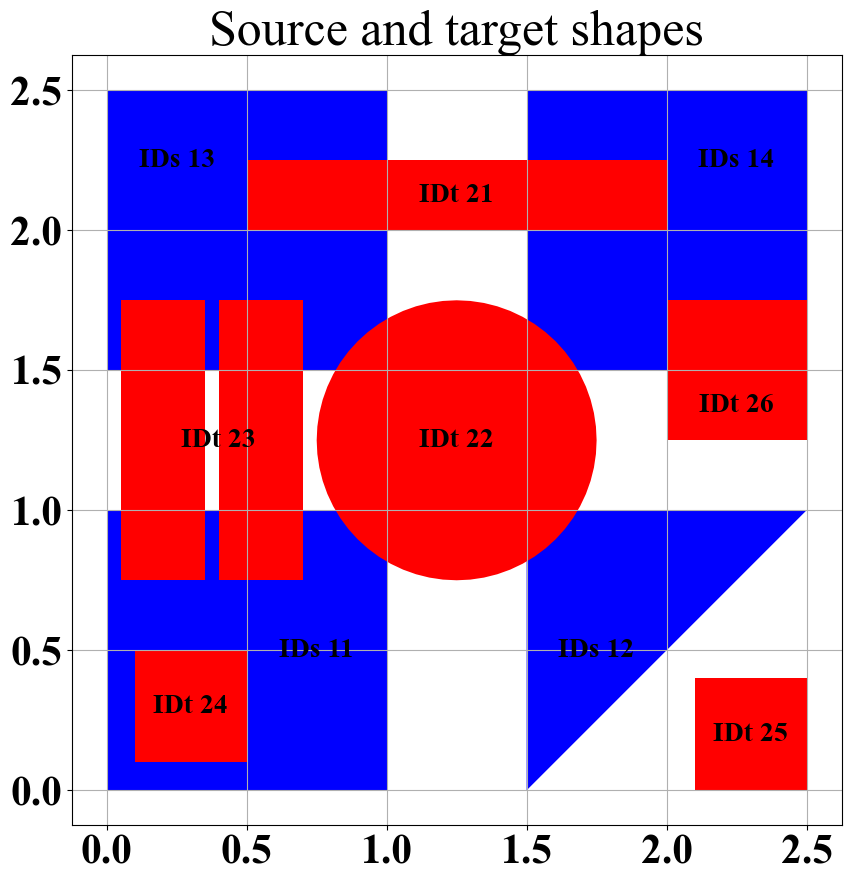

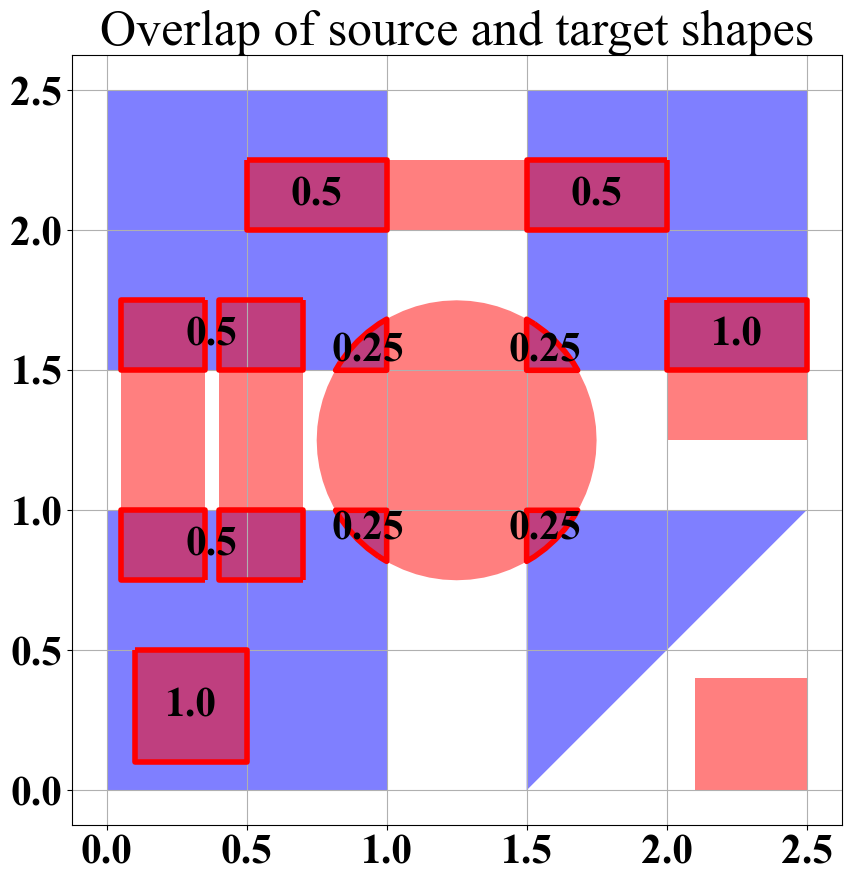

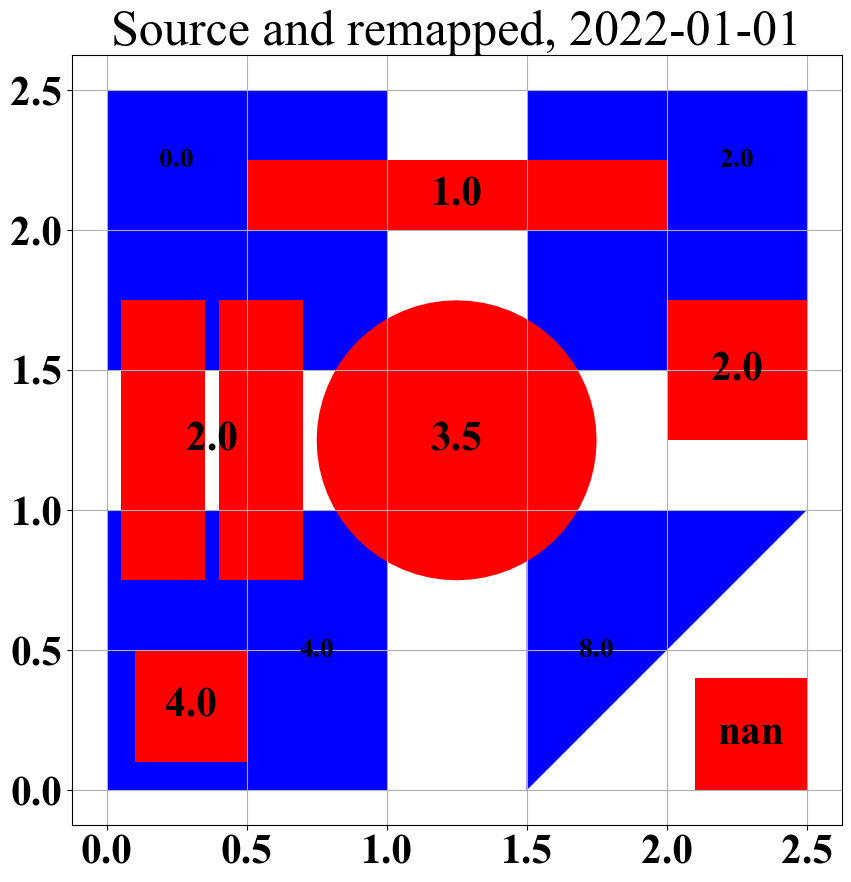

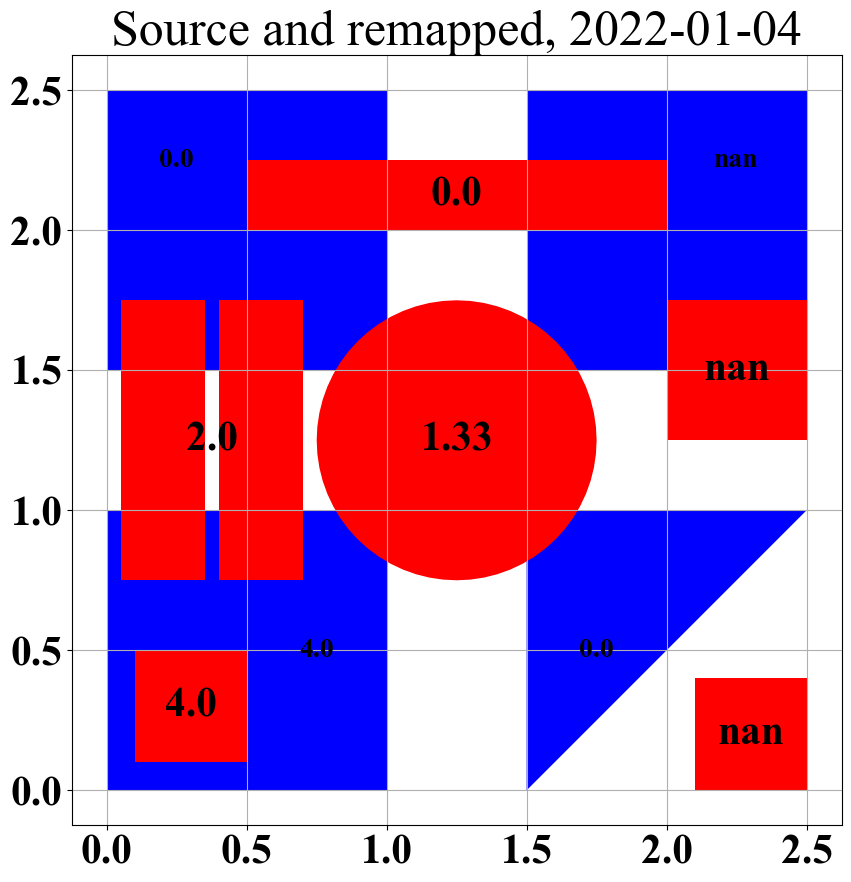

In [5]:

fontsize = 20

import matplotlib

font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)

figsize = (10,10)

if not os.path.isdir('./fig/'):
    os.makedirs('./fig/')


#####
# shapefile depiction
fig, ax = plt.subplots(1,1,figsize=figsize)
fig.set_facecolor("white")

#
source.plot(ax=ax,color='blue')
target.plot(ax=ax,color='red')
plt.grid()

# save
source.to_file(temporary_path+'source.shp')
target.to_file(temporary_path+'target.shp')

# Add the ID of the source shapes
ax.annotate('IDs 11', xy=(0.75,0.5), ha='center', va='center',fontsize = fontsize)
ax.annotate('IDs 12', xy=(1.75,0.5), ha='center', va='center', fontsize = fontsize)
ax.annotate('IDs 13', xy=(0.25,2.25), ha='center',va='center', fontsize = fontsize)
ax.annotate('IDs 14', xy=(2.25,2.25), ha='center',va='center', fontsize = fontsize)
# Add the ID of the target shapes
ax.annotate('IDt 21', xy=(1.25,2.125), ha='center',va='center', fontsize = fontsize)
ax.annotate('IDt 22', xy=(1.25,1.25), ha='center',va='center', fontsize = fontsize)
ax.annotate('IDt 23', xy=(0.4,1.25), ha='center',va='center', fontsize = fontsize)
ax.annotate('IDt 24', xy=(0.3,0.3), ha='center',va='center', fontsize = fontsize)
ax.annotate('IDt 25', xy=(2.3,0.2), ha='center',va='center', fontsize = fontsize)
ax.annotate('IDt 26', xy=(2.25,1.375), ha='center',va='center',fontsize = fontsize)

plt.title('Source and target shapes')

plt.savefig('./fig/test01.png', bbox_inches='tight',dpi=400)

#####
# shapefile depiction
fig, ax = plt.subplots(1,1,figsize=figsize)
fig.set_facecolor("white")

#
source.plot(ax=ax,color='blue', alpha = 0.5)
target.plot(ax=ax,color='red',alpha = 0.5)
plt.grid()

shp_int = gpd.read_file('./temporary/test_example_intersected_shapefile.gpkg')
shp_int['center_x'] = shp_int.centroid.x
shp_int['center_y'] = shp_int.centroid.y
shp_int['AP1N'] = shp_int['AP1N'].round(2)
shp_int.geometry.boundary.plot(color=None,edgecolor='r',linewidth = 4, ax = ax)

for index, row in shp_int.iterrows():    
    ax.annotate(str(row['AP1N']), xy=row['geometry'].centroid.coords[0], ha='center', va='center', fontsize = 30)

plt.title('Overlap of source and target shapes')

plt.savefig('./fig/test02.png', bbox_inches='tight',dpi=400)

#####
# shapefile depiction
fig, ax = plt.subplots(1,1,figsize=figsize)
fig.set_facecolor("white")

#
source.plot(ax=ax,color='blue')
target.plot(ax=ax,color='red')
plt.grid()

ds_source = xr.open_dataset('./temporary/source.nc')
ds_source_slice = ds_source.sel(time='2022-01-01 00:00:00', method = 'nearest')
df_source_slice = ds_source_slice.to_dataframe().sort_index()
source_sort = source.sort_values(by='ID_source')
source_sort['values'] = df_source_slice['Precipitation'].values
source_sort
ax.annotate(source_sort.loc[0,'values'], xy=(0.75,0.5), ha='center', va='center',fontsize = fontsize)
ax.annotate(source_sort.loc[1,'values'], xy=(1.75,0.5), ha='center', va='center', fontsize = fontsize)
ax.annotate(source_sort.loc[2,'values'], xy=(0.25,2.25), ha='center',va='center', fontsize = fontsize)
ax.annotate(source_sort.loc[3,'values'], xy=(2.25,2.25), ha='center',va='center', fontsize = fontsize)

ds_remapped = xr.open_dataset('./output/test_example_remapped_source.nc')
ds_remapped_slice = ds_remapped.sel(time='2022-01-01 00:00:00', method = 'nearest')
df_remapped_slice = ds_remapped_slice.to_dataframe().sort_index()
target_sort = target.sort_values(by='ID_target')
target_sort['values'] = df_remapped_slice['Precipitation'].values
target_sort['values'] = target_sort['values'].round(2)
target_sort

for index, row in target_sort.iterrows():
    ax.annotate(str(row['values']), xy=row['geometry'].centroid.coords[0], ha='center', va='center', fontsize = 30)

plt.title('Source and remapped, 2022-01-01')

plt.savefig('./fig/test03.png', bbox_inches='tight',dpi=400)
    
#####
# shapefile depiction
fig, ax = plt.subplots(1,1,figsize=figsize)
fig.set_facecolor("white")

#
source.plot(ax=ax,color='blue')
target.plot(ax=ax,color='red')
plt.grid()

ds_source = xr.open_dataset('./temporary/source.nc')
ds_source_slice = ds_source.sel(time='2022-01-04 00:00:00', method = 'nearest')
df_source_slice = ds_source_slice.to_dataframe().sort_index()
source_sort = source.sort_values(by='ID_source')
source_sort['values'] = df_source_slice['Precipitation'].values
source_sort
ax.annotate(source_sort.loc[0,'values'], xy=(0.75,0.5), ha='center', va='center',fontsize = fontsize)
ax.annotate(source_sort.loc[1,'values'], xy=(1.75,0.5), ha='center', va='center', fontsize = fontsize)
ax.annotate(source_sort.loc[2,'values'], xy=(0.25,2.25), ha='center',va='center', fontsize = fontsize)
ax.annotate(source_sort.loc[3,'values'], xy=(2.25,2.25), ha='center',va='center', fontsize = fontsize)

ds_remapped = xr.open_dataset('./output/test_example_remapped_source.nc')
ds_remapped_slice = ds_remapped.sel(time='2022-01-04 00:00:00', method = 'nearest')
df_remapped_slice = ds_remapped_slice.to_dataframe().sort_index()
target_sort = target.sort_values(by='ID_target')
target_sort['values'] = df_remapped_slice['Precipitation'].values
target_sort['values'] = target_sort['values'].round(2)
target_sort

for index, row in target_sort.iterrows():
    ax.annotate(str(row['values']), xy=row['geometry'].centroid.coords[0], ha='center', va='center', fontsize = 30)

plt.title('Source and remapped, 2022-01-04')

plt.savefig('./fig/test04.png', bbox_inches='tight',dpi=400)


------------------
------------------
# Merging the figures

In [6]:
# merge the two figures into one
from PIL import Image, ImageFont, ImageDraw

image_list = ['fig/test01.png','fig/test02.png']
if image_list:
    images = [Image.open(x) for x in image_list]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    new_im.save('./fig/test0102.png')
    
image_list = ['fig/test03.png','fig/test04.png']
if image_list:
    images = [Image.open(x) for x in image_list]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    new_im.save('./fig/test0304.png')

image_list = ['fig/test0102.png','fig/test0304.png']
if image_list:
    images = [Image.open(x) for x in image_list]
    widths, heights = zip(*(i.size for i in images))
    max_width = max(widths)
    total_height = sum(heights)
    new_im = Image.new('RGB', (max_width, total_height))
    y_offset = 0
    for im in images:
        new_im.paste(im, (0,y_offset))
        y_offset += im.size[1]
    new_im.save('./fig/test01020304.png')

new_im.show()


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/subprocess.py:1052: ResourceWarning: subprocess 2321 is still running
  _warn("subprocess %s is still running" % self.pid,


# If everything goes fine you should get exactly this figure

![test Image](../fig/test.png)